In [1]:
%load_ext autoreload
%autoreload 2

# Calculate the b-factor on ECCO4v4

In [2]:
import numpy as np
import xarray as xr
from xgcm import Grid
import glob
import matplotlib.pyplot as plt

In [3]:
rootdir = '/data2/project/ECCO4v4/'
# neutral density
localdir = 'GAMMAN/*/'
filename = 'GAMMAN_*.nc'
gamma = xr.open_mfdataset(rootdir+localdir+filename)#.drop(['XC','YC','Z','timestep','time_bnds'])
# temperature
localdir = 'nctiles_monthly/THETA/*/'
filename = 'THETA_*.nc'
theta = xr.open_mfdataset(rootdir+localdir+filename)#.drop(['XC','YC','Z','timestep','time_bnds'])
# salinity
localdir = 'nctiles_monthly/SALT/*/'
filename = 'SALT_*.nc'
salt = xr.open_mfdataset(rootdir+localdir+filename)#.drop(['XC','YC','Z','timestep','time_bnds'])

In [4]:
rootdir = '/home/gmacgilchrist/data/ECCO/'
filename = 'ECCO-GRID.nc'
grid = xr.open_dataset(rootdir+filename)

In [5]:
ds = xr.merge([gamma,theta,salt,grid]).rename({'tile':'face'}).isel(time=0)

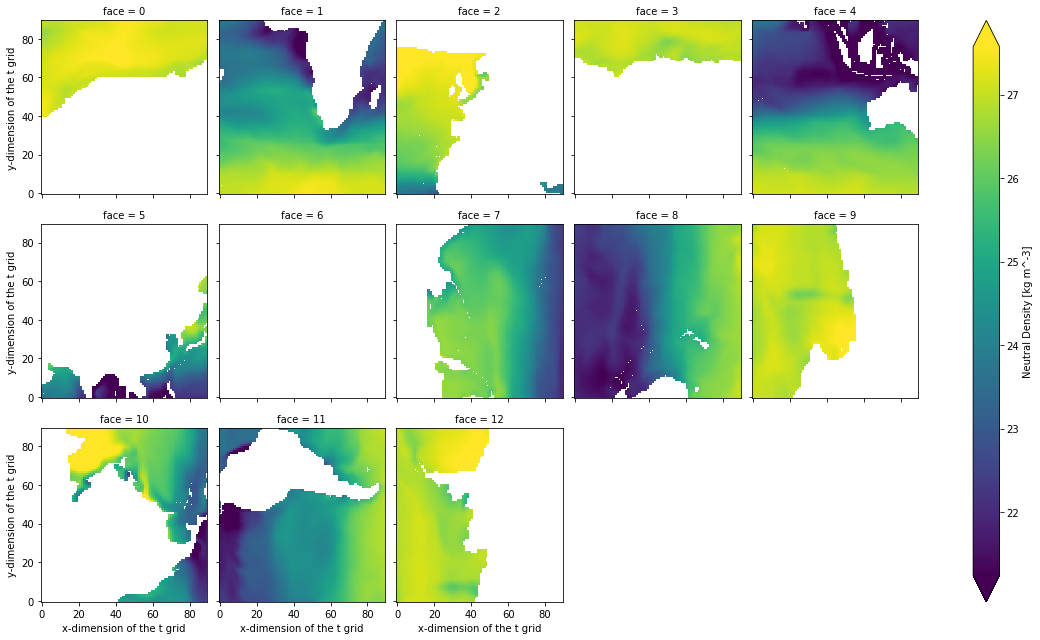

In [6]:
ds['GAMMAN'].isel(k=0).plot(col='face', col_wrap=5, robust=True)

In [7]:
# define the connectivity between faces
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at tracer point

metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}

# create the grid object
xgrid = Grid(ds, periodic=False, face_connections=face_connections, metrics=metrics)
xgrid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * left     k_l --> center
  * outer    k_p1 --> center
  * right    k_u --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center

In [9]:
ds['GAMMAN']

<xarray.DataArray 'GAMMAN' (k: 50, face: 13, j: 90, i: 90)>
dask.array<getitem, shape=(50, 13, 90, 90), dtype=float32, chunksize=(50, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC        (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC        (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z         (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    timestep  int64 dask.array<chunksize=(), meta=np.ndarray>
    time      datetime64[ns] 1992-01-16T12:00:00
    CS        (face, j, i) float32 ...
    SN        (face, j, i) float32 ...
    Depth     (face, j, i) float32 ...
    rA        (face, j, i) float32 ...
    PHrefC    (k) float32 49.05 147.15 245.25 ... 49435.043 53574.863 57940.312
    drC       (k, face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    drF       (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    hFacC     (k, face, j, i) float32 ...
    maskC     (k, face, j, i) bool ...
Attributes:
    units:      kg m^-3
    long_name:  Neutral Density

In [10]:
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, nv: 2)
Coordinates:
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z          (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    timestep   int64 dask.array<chunksize=(), meta=np.ndarray>
    time       datetime64[ns] 1992-01-16T12:00:00
    time_bnds  (nv) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    XG         (face, j_g, i_g) float32 ...
    YG         (face, j_g, i_g) float32 ...
    CS         (face, j, i) float32 ...
    SN         (face, j, i) float32 ...
    Zl         (k_l) float32 0.0 -10.0 -20.0 -30.0 ... -4834.0 -5244.5 -5678.0
    Zu         (k_u) float32 -10.0 -20.0 -30.0 -40.0 ... -5244.5 -5678.0 -6134.5
    Zp1        (k_p1) float32 0.0 -10.0 -20.0 -30.0 ... -5244.5 -5678.0 -6134.5
    dxC        (face, j, i_g) float32 ...
    rAs        (face, j_g, i) float32 ...
    rAw        (face, j, i_g) float32 ...
    Depth      (face, j, i) float32 ...
    rA         (face, j, i) float32 ...
    dxG        (face, j_g, i) float32 ...
    dyG        (face, j, i_g) float32 ...
    rAz        (face, j_g, i_g) float32 ...
    dyC        (face, j_g, i) float32 ...
    PHrefC     (k) float32 49.05 147.15 245.25 ... 49435.043 53574.863 57940.312
    drC        (k, face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PHrefF     (k_p1) float32 0.0 98.1 196.2 ... 51448.547 55701.18 60179.445
    drF        (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    hFacS      (k, face, j_g, i) float32 ...
    hFacC      (k, face, j, i) float32 ...
    hFacW      (k, face, j, i_g) float32 ...
    maskW      (k, face, j, i_g) bool ...
    maskC      (k, face, j, i) bool ...
    maskS      (k, face, j_g, i) bool ...
Dimensions without coordinates: nv
Data variables:
    GAMMAN     (k, face, j, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    THETA      (k, face, j, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    SALT       (k, face, j, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    drW        (k, face, j, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    drS        (k, face, j_g, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [12]:
def dhorz(ds,xgrid,var):
    '''Take horizontal gradient of scalar field given by var.
    Return dictionary of horizontal gradient in each direction.'''
    
    gx = xgrid.interp(ds[var], 'X')
    gy = xgrid.interp(ds[var], 'Y', boundary='fill')
    dg = xgrid.diff_2d_vector({'X':gx,'Y':gy},boundary='fill')
    
    D = xgrid.interp_2d_vector({'X':ds['dxC'],'Y':ds['dyC']},boundary='fill')
    
    return {'X':dg['X']/D['X'],'Y':dg['Y']/D['Y']}

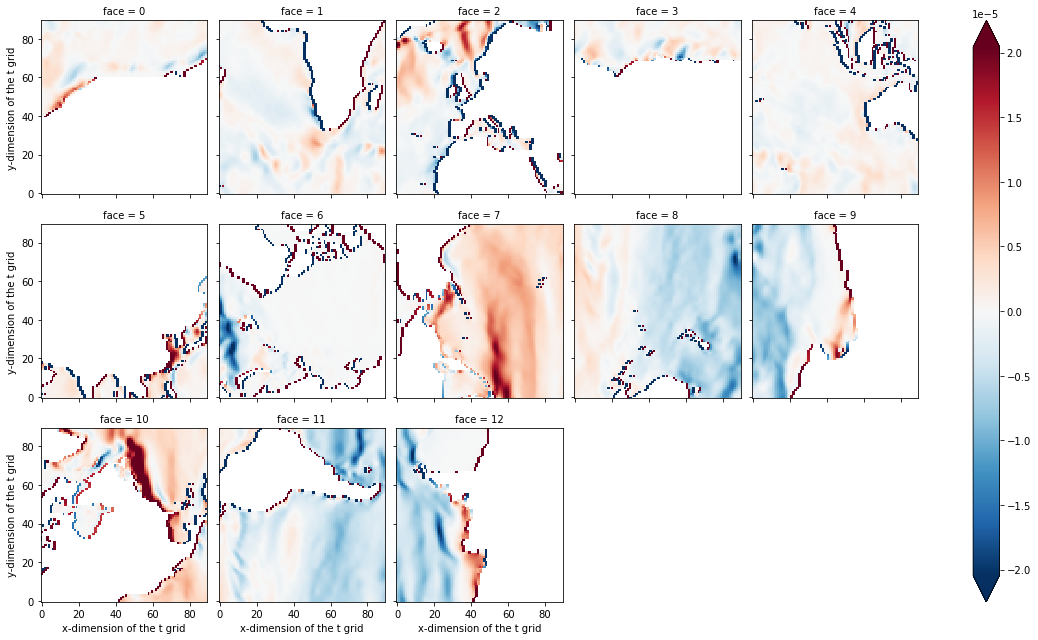

In [18]:
dT = dhorz(ds,xgrid,var='THETA')
dT['X'].where(ds['maskC']).isel(k=0).plot(col='face', col_wrap=5, robust=True)

In [16]:
dT['X']

,Array,Chunk
Bytes,21.06 MB,1.58 MB
Shape,"(50, 13, 90, 90)","(50, 1, 90, 88)"
Count,1714 Tasks,39 Chunks
Type,float32,numpy.ndarray


In [88]:
# Calculate gradients in T, S, and gamma
def dhorz(da):
    C = da.copy()
    dCx = xgrid.diff(C,'X')
    dCdx = dCx/xgrid.get_metric(dCx,'X')
    dCy = xgrid.diff(C,'Y',boundary='fill')
    dCdy = dCy/xgrid.get_metric(dCy,'Y')
    return dCdx, dCdy

# Horizontal
dTdx, dTdy = dhorz(ds['THETA'])
dSdx, dSdy = dhorz(ds['SALT'])
dGdx, dGdy = dhorz(ds['GAMMAN'])

def dvert(da):
    C = da.copy()
    dCz = xgrid.interp(C,'Z',boundary='extrapolate')
    dCdz = xgrid.derivative(dCz, 'Z',boundary='extrapolate')
    return dCdz

# Vertical
dTdz = dvert(ds['THETA'])
dSdz = dvert(ds['SALT'])
dGdz = dvert(ds['GAMMAN'])

In [42]:
# Calculate derivative of locally referenced potential density
rho = ds['rhoinsitu']
alpha = ds['alpha']
beta = ds['beta']

drdx = rho*(-alpha*dTdx + beta*dSdx)
drdy = rho*(-alpha*dTdy + beta*dSdy)
drdz = rho*(-alpha*dTdz + beta*dSdz)

In [43]:
# Calculate absolute magnitude of gradients
absgradr = xr.ufuncs.sqrt(xr.ufuncs.square(drdx)+
                          xr.ufuncs.square(drdy)+
                          xr.ufuncs.square(drdz))
absgradg = xr.ufuncs.sqrt(xr.ufuncs.square(dgdx)+
                          xr.ufuncs.square(dgdy)+
                          xr.ufuncs.square(dgdz))

In [44]:
# Calculate b as ratio
b = absgradg/absgradr

In [45]:
b.load();

<ipython-input-55-08d7ea99cc74>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['geolat'].sel(select,method='nearest'),


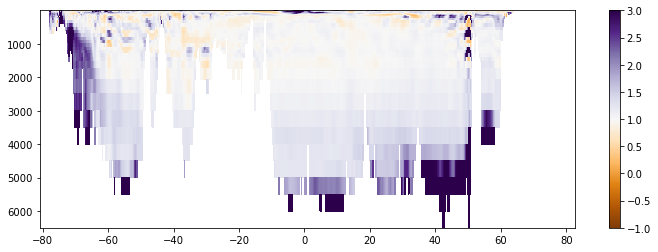

In [55]:
select = {'xh':-180}
fig,ax = plt.subplots(figsize=(12,4))
im = ax.pcolormesh(ds['geolat'].sel(select,method='nearest'),
                   ds['z_l'],
                   b.sel(select,method='nearest').transpose(),
                   vmin=-1,vmax=3,cmap='PuOr')
plt.colorbar(im,ax=ax)
ax.invert_yaxis()

<ipython-input-51-927c4415ce7f>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['geolat'].sel(select,method='nearest'),


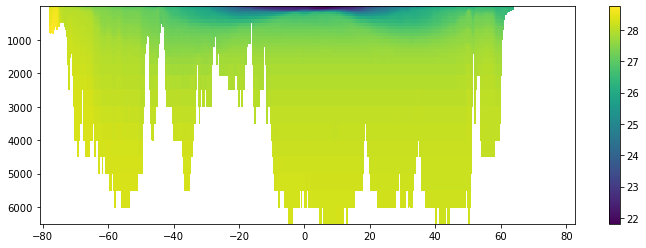

In [51]:
select = {'xh':-180}
fig,ax = plt.subplots(figsize=(12,4))
im = ax.pcolormesh(ds['geolat'].sel(select,method='nearest'),
           ds['z_l'],
           ds['g'].sel(select,method='nearest').transpose())
ax.invert_yaxis()
plt.colorbar(im,ax=ax)